# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the advection diffusion PDE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointAdvectionDiffusionModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which includes the start and end times of the observation period and the x and y locations that the observation was taken at. Consider an array of four sensors in a grid that each take two time averaged readings. 

In [15]:
#X = np.asarray([[1,2],[3,4],[5,6],[7,8]]) #[t_lower,t_upper,x_location,y_location]


tlocL = np.linspace(1,9,20) # lower time
X= np.zeros((len(tlocL),2)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+1 # upper time

Text(0.5, 1.0, 'Sensor Locations')

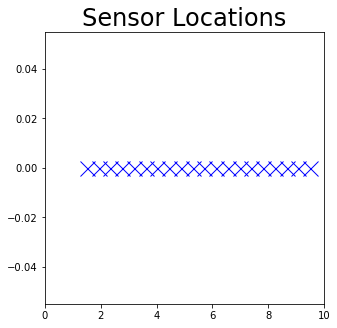

In [16]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot((X[:,1]-1/2),np.zeros(len(X)),'xk',markersize=15,color='b')
plt.xlim(0,10)
plt.title("Sensor Locations",fontsize=24)

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [17]:
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging (second argument)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a 10x10x10 grid in space and time.

### Establish forward model parameters

In [18]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# corners of the grid - in units of space
kForward = EQ(np.sqrt(0.6), 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [100] # grid size for time, x and y

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [19]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.zeros(m.resolution)
#sourceGT[7:17] = 1.0 # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

10 20 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
14 24 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
18 28 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
22 32 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
26 36 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
31 41 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
35 45 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
39 49 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
43 53 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
47 57 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
52 62 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
56 66 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
60 70 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
64 74 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
68 78 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
73 83 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
77 87 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
81 91 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
85 95 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
90 100 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


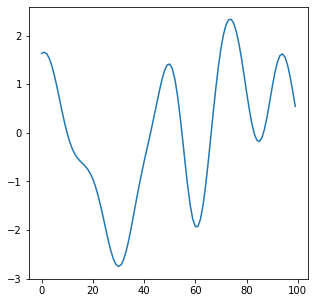

In [20]:
plt.plot(np.array(sourceGT))

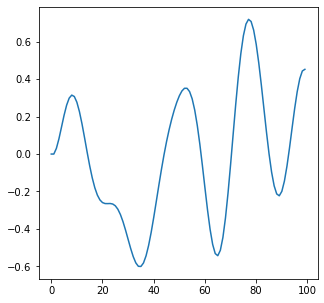

In [21]:
plt.plot(concTrain)

In [22]:
yTrain

array([-0.00719747, -0.18770168, -0.26798029, -0.34203004, -0.46779977,
       -0.52070494, -0.34791682, -0.06464709,  0.18072636,  0.29132026,
        0.12278583, -0.20647786, -0.39521286, -0.18563807,  0.27638372,
        0.58100315,  0.37997191,  0.03168965, -0.09369463,  0.16388148])

# Inverse Problem Example

Calculating Adjoints...
10 20 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
14 24 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
18 28 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
22 32 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
26 36 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
31 41 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
35 45 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
39 49 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
43 53 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
47 57 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
52 62 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
56 66 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
60 70 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
64 74 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
68 78 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
73 83 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
77 87 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
81 91 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
85 95 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
90 100 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
19/20 
Calculating Phis...
1999/2000 


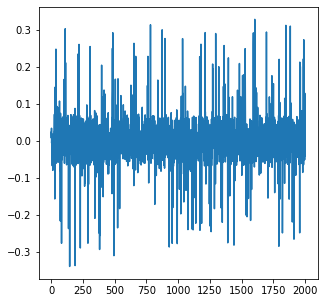

In [23]:
N_feat =20 #Number of features used to infer the source
kInverse = EQ(np.sqrt(0.6), 4) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
m.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = m.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = m.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source
plt.plot(meanZ)

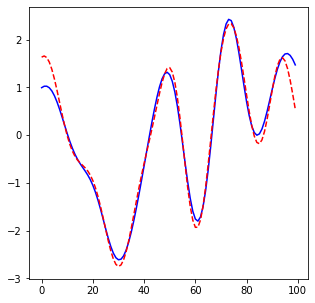

In [24]:
xtest=np.arange(Nt)
plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

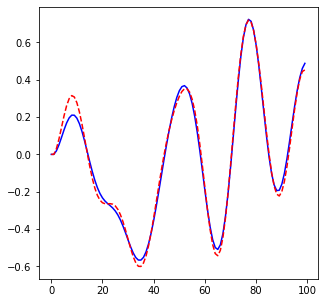

In [25]:
xtest=np.arange(Nt)
plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

10 20 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
13 23 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
17 27 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
21 31 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
24 34 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
28 38 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
32 42 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
35 45 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
39 49 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
43 53 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
46 56 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
50 60 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
54 64 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
57 67 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
61 71 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
65 75 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
68 78 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
72 82 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
76 86 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
80 90 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


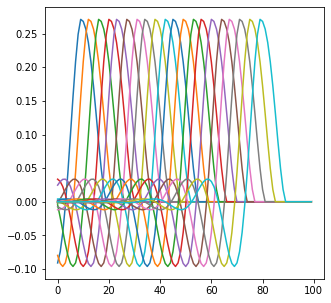

In [13]:
for j,H in enumerate(m.sensormodel.getHs1D(m)):
            print("%d/%d \r" % (j,len(m.sensormodel.obsLocs)),end="")
            plt.plot(m.computeAdjoint(H))

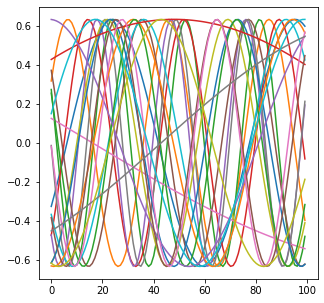

In [26]:
for i,phi in enumerate(mInfer.kernel.getPhi1D(mInfer.coords)):
    plt.plot(phi)

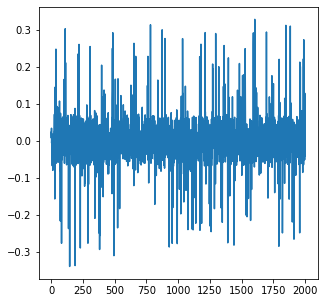

In [27]:
plt.plot(meanZ)